<a href="https://colab.research.google.com/github/KeremAydin98/fsrcnn-implementation/blob/main/fsrcnn_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import albumentations as A
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
# Data path
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Projects/fsrcnn/T91"

# Png extension
EXTENSION = ".png"

# From the smallest image in the dataset
HR_TARGET_SHAPE = (76,76)

# Rescaling factor
RESCALING_FACTOR = 4

# Colored images
COLOR_CHANNELS = 3

LR_TARGET_SHAPE = (HR_TARGET_SHAPE[0] // 4, HR_TARGET_SHAPE[1] // 4)

# Configurations
d = 56
s = 12
m = 4

# Bicubic Downsample
DOWNSAMPLE_MODE = Image.BICUBIC

In [4]:
class T91Dataset(tf.keras.utils.Sequence):

    def __init__(self,batch_size, which_type, color_channels):

        self.batch_size = batch_size
        self.data_path = DATA_PATH
        self.extension = EXTENSION
        self.color_channels = color_channels

        # Get file paths
        img_files = os.listdir(self.data_path)

        # Load the images
        images = [Image.open(os.path.join(self.data_path, f)) for f in img_files if f.endswith(self.extension)]

        train_test = 0.7
        val_test = 0.66

        # Train images
        train_images = images[:int(len(images) * train_test)]

        val_test_images = images[int(len(images) * train_test):]

        # Validation images
        val_images = val_test_images[:int(len(val_test_images) * val_test)]

        # Test images
        test_images = val_test_images[int(len(val_test_images) * val_test):]

        if which_type == "train":

            self.dataset = train_images

        elif which_type == "validation":

            self.dataset = val_images

        else:

            self.dataset = test_images

        if which_type in ["train", "val"]:

            self.transform = A.Compose([
                    A.RandomCrop(width=HR_TARGET_SHAPE[0], height=HR_TARGET_SHAPE[1]),
                    A.Downscale(scale_min=0.6, scale_max=0.9, always_apply=True),
                    A.HorizontalFlip(p=0.5),
                    A.Rotate(limit=270)
                ])

        else:

            self.transform = A.Compose([
                    A.RandomCrop(width=HR_TARGET_SHAPE[0], height=HR_TARGET_SHAPE[1])
                ])

        self.to_float = A.ToFloat(max_value=255)

    def __len__(self):

        return len(self.dataset) // self.batch_size

    def __getitem__(self, item):

        index = item * self.batch_size

        batch_images = self.dataset[index:index + self.batch_size]

        batch_hr_images = np.zeros((self.batch_size,) + HR_TARGET_SHAPE + (self.color_channels,))
        batch_lr_images = np.zeros((self.batch_size,) + LR_TARGET_SHAPE + (self.color_channels,))


        for i, image_fn in enumerate(batch_images):

            hr_image_transform = self.transform(image=np.array(image_fn))["image"]
            hr_image_transform_pil = Image.fromarray(hr_image_transform)

            lr_image_transform_pil = hr_image_transform_pil.resize(
                LR_TARGET_SHAPE, resample=DOWNSAMPLE_MODE
            )

            lr_image_transform = np.array(lr_image_transform_pil)

            batch_hr_images[i] = self.to_float(image=hr_image_transform)["image"]
            batch_lr_images[i] = self.to_float(image=lr_image_transform)["image"]

        return (batch_lr_images, batch_hr_images)

In [23]:
def create_model(d:int,
                 s:int,
                 m:int,
                 rescaling:int,
                 color_channels:int,
                 input_size:tuple = LR_TARGET_SHAPE):


    # Input layer
    inputs = tf.keras.layers.Input(shape=(input_size[0], input_size[1], color_channels))

    # Feature Extraction
    x = tf.keras.layers.Conv2D(filters = d,
                               kernel_size = 5,
                               padding="same",
                               kernel_initializer=tf.keras.initializers.HeNormal)(inputs)
    x = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)

    # Shrinking layer
    x = tf.keras.layers.Conv2D(filters = s,
                               kernel_size = 1,
                               padding="same",
                               kernel_initializer=tf.keras.initializers.HeNormal)(x)
    x = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)

    # Mapping layers
    for i in range(m):
        x = tf.keras.layers.Conv2D(filters = s,
                                   kernel_size = 3,
                                   padding="same",
                                   kernel_initializer=tf.keras.initializers.HeNormal)(x)
        x = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)

    # Expanding layer
    x = tf.keras.layers.Conv2D(filters = d,
                               kernel_size = 1,
                               padding="same",
                               kernel_initializer=tf.keras.initializers.HeNormal)(x)
    x = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)

    # Deconvolution layer
    # Stride = upscaling factor
    outputs = tf.keras.layers.Conv2DTranspose(filters=color_channels,
                                              kernel_size = 9,
                                              strides=rescaling,
                                              padding="same",
                                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001, seed=None))(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(loss=tf.keras.losses.mse,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

    return model


def get_callbacks():

    return [tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.8, patience=10),
            tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=50,restore_best_weights=True),
            tf.keras.callbacks.ModelCheckpoint(monitor="val_loss", filepath="checkpoint.h5",save_best_only=True)]

In [24]:
train_data = T91Dataset(batch_size=2,
                             which_type="train",
                            color_channels=COLOR_CHANNELS)


val_data = T91Dataset(batch_size=2,
                           which_type="validation",
                          color_channels=COLOR_CHANNELS)

model = create_model(d=d,
                         s=s,
                         m=m,
                         rescaling=RESCALING_FACTOR,
                         color_channels=COLOR_CHANNELS)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 19, 19, 3)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 19, 19, 56)        4256      
                                                                 
 p_re_lu_14 (PReLU)          (None, 19, 19, 56)        56        
                                                                 
 conv2d_15 (Conv2D)          (None, 19, 19, 12)        684       
                                                                 
 p_re_lu_15 (PReLU)          (None, 19, 19, 12)        12        
                                                                 
 conv2d_16 (Conv2D)          (None, 19, 19, 12)        1308      
                                                                 
 p_re_lu_16 (PReLU)          (None, 19, 19, 12)        12  

In [25]:
history = model.fit(train_data, validation_data=val_data, epochs=500, steps_per_epoch=len(train_data), validation_steps=int(len(val_data)*0.15), callbacks=get_callbacks())

Epoch 1/500
31/31 [==============================] - 2s 20ms/step - loss: 0.0855 - val_loss: 0.0435 - lr: 0.0010
Epoch 2/500
31/31 [==============================] - 0s 11ms/step - loss: 0.0403 - val_loss: 0.0253 - lr: 0.0010
Epoch 3/500
31/31 [==============================] - 0s 10ms/step - loss: 0.0313 - val_loss: 0.0226 - lr: 0.0010
Epoch 4/500
31/31 [==============================] - 0s 9ms/step - loss: 0.0276 - val_loss: 0.0131 - lr: 0.0010
Epoch 5/500
31/31 [==============================] - 0s 8ms/step - loss: 0.0234 - val_loss: 0.0162 - lr: 0.0010
Epoch 6/500
31/31 [==============================] - 0s 10ms/step - loss: 0.0204 - val_loss: 0.0096 - lr: 0.0010
Epoch 7/500
31/31 [==============================] - 0s 10ms/step - loss: 0.0192 - val_loss: 0.0095 - lr: 0.0010
Epoch 8/500
31/31 [==============================] - 0s 10ms/step - loss: 0.0194 - val_loss: 0.0078 - lr: 0.0010
Epoch 9/500
31/31 [==============================] - 0s 8ms/step - loss: 0.0172 - val_loss: 0.0102

In [30]:
model = tf.keras.models.load_model("checkpoint.h5")

In [27]:
test_data = T91Dataset(batch_size=8,
                           which_type="test",
                          color_channels=COLOR_CHANNELS)

In [28]:
batch_id = 0
batch = test_data.__getitem__(batch_id)
preds = model.predict(batch[0])

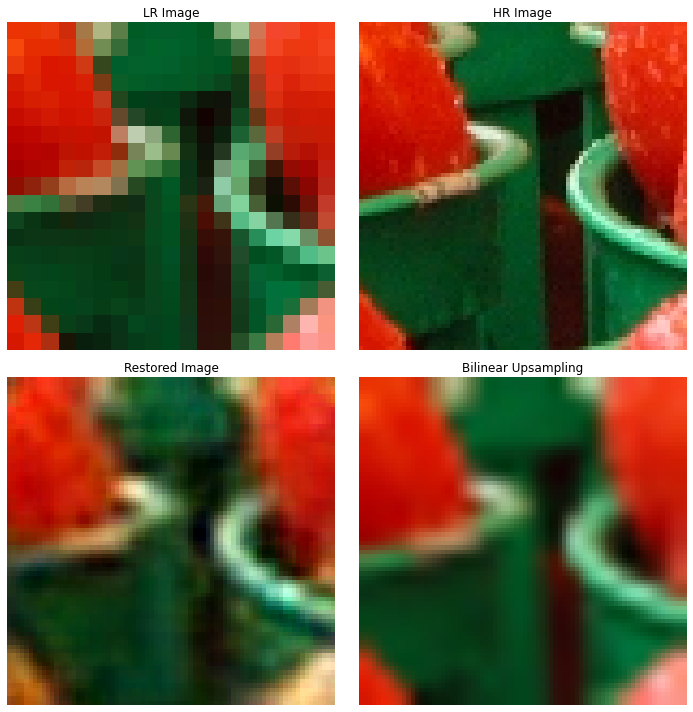

In [29]:
img_id = 0

plt.figure(figsize=[10, 10])
plt.subplot(2, 2, 1)
plt.imshow(batch[0][img_id])
plt.axis("off")
plt.title("LR Image")

plt.subplot(2, 2, 2)
plt.imshow(batch[1][img_id])
plt.axis("off")
plt.title("HR Image")

plt.subplot(2, 2, 3)
plt.imshow(preds[img_id] )
plt.axis("off")
plt.title("Restored Image")


plt.subplot(2, 2, 4)
lr_image = Image.fromarray(np.array(batch[0][img_id] * 255, dtype="uint8"))
lr_image_resized = lr_image.resize(HR_TARGET_SHAPE, resample=DOWNSAMPLE_MODE)
plt.imshow(lr_image_resized)
plt.axis("off")
plt.title("Bilinear Upsampling")

plt.tight_layout()
plt.show()